# Hyperparameter Tuning for Random Forest Classifier
**Prepared by:** Yongli Chen and Adisorn Promkaewngarm

# Import Library

In [ ]:
!pip -q install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
import mplfinance as mpf

# Import Data

In [ ]:
# GitHub Raw Data Paths
path_feature = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_SET_features_weekly.csv'
path_label_train = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_regime_labeling_traindata_weekly.csv'
path_set_data = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/SET_Index_Weekly_2010_2025.csv'

# 1. Load the feature set
df_features = pd.read_csv(path_feature, index_col=0, parse_dates=True)

  # Train-Test split by period
df_features_train = df_features.loc[df_features.index.year < 2023].copy()
df_features_train = df_features_train.iloc[:, 1:] # Remove currnet return

  # Train-Test split by period
df_features_test = df_features.loc[df_features.index.year >= 2023,].copy()
df_features_test = df_features_test.iloc[:, 1:] # Remove currnet return

# 2. Load the training labels
df_labels = pd.read_csv(path_label_train, index_col=0, parse_dates=True)
df_labels_train = df_labels['Regime_ID'].copy()

# 3. Load the raw SET Index OHLC data
df_set_index = pd.read_csv(path_set_data, index_col=0, parse_dates=True)

In [ ]:
# 1. Check Training Set Alignment (Features vs. GM-HMM Labels)
train_indices_match = df_features_train.index.equals(df_labels_train.index)

# Define df_set_index_test here to resolve NameError
df_set_index_test = df_set_index.loc[df_set_index.index.year >= 2023].copy()

# 2. Check Testing Set Alignment (Features vs. Raw SET Index)
test_indices_match = df_features_test.index.equals(df_set_index_test.index)

# 3. Print Results
print("="*50)
print("INDEX CONSISTENCY VERIFICATION")
print("="*50)
print(f"Training Set Indices Match: {train_indices_match}")
print(f"Testing Set Indices Match:  {test_indices_match}")
print("-" * 50)

# If they don't match, let's see where the discrepancy is
if not train_indices_match:
    print(f"Training Features: {len(df_features_train)} rows")
    print(f"Training Labels:   {len(df_labels_train)} rows")
    # Finding the difference
    diff = df_features_train.index.difference(df_labels_train.index)
    print(f"Missing dates in labels: {len(diff)}")

if not test_indices_match:
    print(f"Testing Features:  {len(df_features_test)} rows")
    print(f"Testing SET Data:  {len(df_set_index_test)} rows")
print("="*50)

INDEX CONSISTENCY VERIFICATION
Training Set Indices Match: True
Testing Set Indices Match:  True
--------------------------------------------------


# Data Normalization

In [ ]:
# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit and Transform the Training Data
X_train_scaled = scaler.fit_transform(df_features_train)

# 3. Transform the Testing Data (using the training parameters)
X_test_scaled = scaler.transform(df_features_test)

# Convert back to DataFrame to maintain column names for XGBoost
X_train_final = pd.DataFrame(X_train_scaled, index=df_features_train.index, columns=df_features_train.columns)
X_test_final = pd.DataFrame(X_test_scaled, index=df_features_test.index, columns=df_features_test.columns)

# Hyperparameter Tuning

In [ ]:
# Set to True to run hyperparameter tuning; Set to False once best_rf_model is saved
run_rf_tuning = False

if run_rf_tuning:
    # Setup Random Forest Classifier
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight='balanced',  # Handle class imbalance
        n_jobs=-1,  # Use all CPU cores
        oob_score=True  # Enable out-of-bag score for additional validation
    )

    # Parameter distribution for Randomized Search
    param_dist_rf = {
        'n_estimators': randint(100, 200, 500),  # Number of trees in the forest
        'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
        'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
        'min_samples_leaf': randint(1, 10),  # Minimum number of samples required at a leaf node
        'max_features': ['sqrt', 'log2', None, 0.5, 0.7, 0.9],  # Number of features to consider for best split
        'bootstrap': [True, False],  # Whether bootstrap samples are used
        'criterion': ['gini', 'entropy']  # Splitting criterion
    }

    # TimeSeriesSplit for time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Randomized Search
    n_iter_rf = 100  # Same as XGBoost

    random_search_rf = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist_rf,
        n_iter=n_iter_rf,
        cv=tscv,
        scoring='f1_macro',
        verbose=2,
        n_jobs=-1,
        random_state=42,
        refit=True
    )

    print(f"\nStarting Random Forest Randomized Search with {n_iter_rf} iterations...")
    print(f"Training samples: {len(X_train_final)}")
    print(f"Features: {X_train_final.shape[1]}")
    print(f"Classes: {len(np.unique(df_labels_train))}")
    print("-" * 50)

    # Check class distribution
    print("Class distribution in training data:")
    class_counts = pd.Series(df_labels_train).value_counts().sort_index()
    for cls, count in class_counts.items():
        regime_name = {0: 'Sideway', 1: 'Bull', 2: 'Bear'}[cls]
        print(f"  {regime_name} (Class {cls}): {count} samples ({count/len(df_labels_train)*100:.1f}%)")

    start_time = time.time()
    random_search_rf.fit(X_train_final, df_labels_train)
    duration = time.time() - start_time

    print("\n" + "="*50)
    print(f"RANDOM FOREST RANDOMIZED SEARCH COMPLETED")
    print(f"Total Time Spent:  {duration:.2f} seconds ({duration/60:.2f} minutes)")
    print("-" * 50)
    print(f"Best Parameters:   {random_search_rf.best_params_}")
    print(f"Best CV Accuracy:  {random_search_rf.best_score_:.4f}")
    print(f"Out-of-Bag Score:  {random_search_rf.best_estimator_.oob_score_:.4f}")
    print("="*50)

    # Assign the best model
    best_rf_model = random_search_rf.best_estimator_

    # Display detailed results
    results_df = pd.DataFrame(random_search_rf.cv_results_)
    print("\nTop 5 Random Forest Parameter Combinations:")
    top_results = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('mean_test_score', ascending=False).head(5)
    print(top_results.to_string())

    # Save results to CSV for reference
    results_df.to_csv('rf_tuning_results.csv', index=False)
    print("\nFull results saved to: rf_tuning_results.csv")

else:
    print("Skipping Random Forest tuning: Using previously defined best_rf_model.")

Skipping Random Forest tuning: Using previously defined best_rf_model.


Tuning based on Accuracy

Best Parameters:   

{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2, 'min_samples_leaf': 2, 'min_samples_split': 19, 'n_estimators': 634}

Best CV Accuracy:  0.5135
Out-of-Bag Score:  0.4856

# Model Training

In [ ]:
if not run_rf_tuning:
  from sklearn.ensemble import RandomForestClassifier

  # Initialize the final model using the best parameters found
  best_rf_model = RandomForestClassifier(
      n_estimators=634,
      min_samples_split=19,
      min_samples_leaf=2,
      max_features='log2',
      max_depth=None,
      criterion='gini',
      bootstrap=True,
      oob_score=True,
      random_state=42,
      n_jobs=-1  # Uses all available cores for faster training
  )

  # Fit the model
  best_rf_model.fit(X_train_final, df_labels_train)

print("Random Forest model training complete.")

Random Forest model training complete.



Random Forest Training Set Performance (2011-2022):
--------------------------------------------------
              precision    recall  f1-score   support

    Sideways       0.95      1.00      0.98       249
        Bear       0.99      0.98      0.98       201
        Bull       0.98      0.93      0.95       176

    accuracy                           0.97       626
   macro avg       0.98      0.97      0.97       626
weighted avg       0.97      0.97      0.97       626



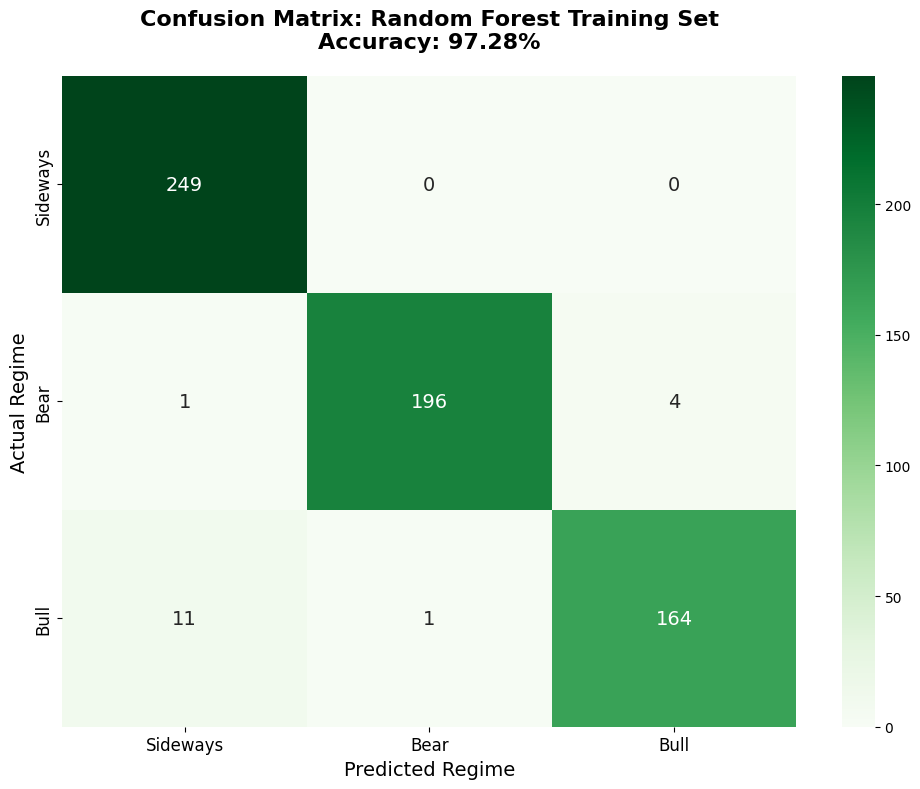

In [ ]:
final_rf_model = best_rf_model

# Make predictions
y_train_pred_rf = final_rf_model.predict(X_train_final)
y_train_prob_rf = final_rf_model.predict_proba(X_train_final)

y_test_pred_rf = final_rf_model.predict(X_test_final)
y_test_prob_rf = final_rf_model.predict_proba(X_test_final)

# Performance metrics
print("\nRandom Forest Training Set Performance (2011-2022):")
print("-" * 50)
train_report = classification_report(df_labels_train, y_train_pred_rf,
                                      target_names=['Sideways', 'Bear', 'Bull'])
print(train_report)

# ========== CONFUSION MATRIX ==========
cm_train_rf = confusion_matrix(df_labels_train, y_train_pred_rf)

# Create a single figure for confusion matrix
plt.figure(figsize=(10, 8))

# Confusion Matrix Heatmap
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Sideways', 'Bear', 'Bull'],
            yticklabels=['Sideways', 'Bear', 'Bull'],
            annot_kws={"size": 14})

# Calculate accuracy for display
accuracy = accuracy_score(df_labels_train, y_train_pred_rf)

plt.title(f'Confusion Matrix: Random Forest Training Set\nAccuracy: {accuracy:.2%}',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Regime', fontsize=14)
plt.ylabel('Actual Regime', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


# Save Model

In [ ]:
if False: # Set true to export model
  model_filename = 'model_RF_regime_prediction.json'
  best_RF_model.save_model(model_filename)